In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
from spyglass.decoding.v1.waveform_features import UnitWaveformFeatures

times_list, marks_list = (
    UnitWaveformFeatures()
    & {"features_param_name": "amplitude_probe"}
    & "analysis_file_name LIKE 'wilbur20210404%'"
).fetch_data()

[2025-11-19 13:44:48,955][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-11-19 13:44:48,989][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/non_local_detector/likelihoods/clusterless_kde.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[2025-11-19 13:45:14,328][WARNING]: Skipped checksum for file with hash: e3a99702-abe1-398d-a7ac-4f90aa189e32, and path: /stelmo/nwb/analysis/wilbur20210404/wilbur20210404_7M6KBR92WS.nwb
[2025-11-19 13:45:14,336][WARNING]: Skipped checksum for file with hash: e3a99702-abe1-398d-a7ac-4f90aa189e32, and path: /stelmo/nwb/analysis/wilbur20210404/wilbur20210404_7M6KBR92WS.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(

In [3]:
subsample = 1
mark_times = []
marks = []

n_shanks = len(times_list)

for shank, (t, m) in enumerate(zip(times_list, marks_list)):
    mark_times.extend(t)
    # mark = np.zeros((len(t),m.shape[1],n_shanks))
    # mark[:, :, shank] = m
    # marks.extend(mark)
    mark = np.zeros((len(t), 32 + 1))
    mark[:, : m.shape[1]] = m
    mark[:, -1] = shank
    marks.extend(mark)
    # break


marks = np.array(marks)
mark_times = np.array(mark_times)
print(marks.shape, mark_times.shape)

ind = np.argsort(mark_times)
mark_times = mark_times[ind]
marks = marks[ind]

# standardize marks
marks[:, :-1] = marks[:, :-1] - np.mean(marks[:, :-1], axis=1)[:, None]
#     :, None, :
# ]
# standardize times
first_mark_time = mark_times[0]
mark_times = mark_times - first_mark_time
# mark_times[mark_times > 10] = 10
mark_times = mark_times * 1000
# print(np.max(np.abs(marks)))
marks[:, :-1] = marks[:, :-1] / 1000  # np.max(np.abs(marks))

marks = marks[::subsample]
mark_times = mark_times[::subsample]

(36937458, 33) (36937458,)


In [4]:
# prep data for model
delta_t = np.diff(mark_times)[None, ...]
# delta_t[delta_t >10] = 10
x = marks[1:][None, ...]


ind = np.where(delta_t[0] > 0)[0]
x = x[:, ind]
marks = marks[ind]
mark_times = mark_times[ind]
delta_t = delta_t[:, ind]  # *1000

## Trial info

In [ ]:
import os

os.chdir("/home/xulu/code/alison_spyglass")
# from alison_subject import SpatialBanditSubjects
from alison_behav import *

# from alison_rlmodel import BehaviorModelResults

# # from alison_position import PosValidTimesToEpoch

import datajoint as dj
from spyglass.utils.dj_helper_fn import fetch_nwb
from spyglass.common import AnalysisNwbfile

behavior_model_table = dj.FreeTable(
    dj.conn(), "`alison_rlmodel`.`__behavior_model_results__by_day`"
)

subject = "wilbur"
date = "20210404"
file_name = subject + date
nwb_file_name = file_name + "_.nwb"
behavior_model_params_name = "default_hmm"
trials_info_by_rat_params_name = "decay_default"  # For some animals or sessions it could be 'decay_default2' where Alison reran the HMM
behav_results = behavior_model_table & {
    "nwb_file_name": nwb_file_name,
    "behavior_model_params_name": behavior_model_params_name,
    "trials_info_by_rat_params_name": trials_info_by_rat_params_name,
}
# all_behav = behav_results.fetch1_dataframe()
all_behav = fetch_nwb(behav_results, (AnalysisNwbfile, "analysis_file_abs_path"))[0][
    "behavior_model_results_by_day"
]
all_behav

behav_results
script_table = StateScriptTrials() & {"nwb_file_name": nwb_file_name}
trials = []
epoch = []
t_poke = []
t_out = []
for epoch_i in script_table.fetch("epoch"):
    table = script_table & {"epoch": epoch_i}
    trials.extend(table.fetch1("trial"))
    epoch.extend([epoch_i] * len(table.fetch1("trial")))
    t_poke.extend(table.fetch1("poke_in_ts"))
    t_out.extend(table.fetch1("poke_out_ts"))
script_df = pd.DataFrame(
    {"epoch": epoch, "trial_number_by_epoch": trials, "t_poke": t_poke, "t_out": t_out},
)
script_df

##
trial_df = pd.merge(all_behav, script_df, on=["epoch", "trial_number_by_epoch"])
turn_lookup = {
    (1, 2): "right",
    (2, 1): "left",
    (3, 4): "right",
    (4, 3): "left",
    (5, 6): "right",
    (6, 5): "left",
}

fill_entries = [
    (1, "left", [3, 4, 5, 6]),
    (2, "right", [3, 4, 5, 6]),
    (3, "left", [1, 2, 5, 6]),
    (4, "right", [1, 2, 5, 6]),
    (5, "left", [1, 2, 3, 4]),
    (6, "right", [1, 2, 3, 4]),
]
for fill_entry in fill_entries:
    port, turn, other_ports = fill_entry
    for other_port in other_ports:
        turn_lookup[(port, other_port)] = turn

turns = []
for epoch in trial_df["epoch"].unique():
    epoch_df = trial_df[trial_df["epoch"] == epoch]
    turns.append("start")
    for i in range(1, len(epoch_df)):
        turn = turn_lookup[(epoch_df["leaf"].values[i - 1], epoch_df["leaf"].values[i])]
        turns.append(turn)
if "turns" not in trial_df.columns:
    trial_df["turns"] = turns


from spyglass.common import Nwbfile
from pynwb import NWBHDF5IO
from spyglass.utils.nwb_helper_fn import get_nwb_file
from spyglass.utils.dj_helper_fn import _get_nwb_object
from spyglass.common import DIOEvents, Nwbfile, interval_list_intersect
import numpy as np

file_path = Nwbfile().get_abs_path("wilbur20210404_.nwb")
nwb = get_nwb_file(file_path)
dio_query = (
    DIOEvents()
    & {"nwb_file_name": "wilbur20210404_.nwb"}
    & "dio_event_name LIKE 'pump%'"
)

pump_obj_ids = dio_query.fetch("dio_object_id")
all_pump_intervals = []
for obj_id in pump_obj_ids:
    obj = _get_nwb_object(nwb.objects, obj_id)
    state = obj.data[:]
    state_time = obj.timestamps[:]
    ind_on = np.where(state == 1)[0]
    pump_intervals = [
        [st, en] for st, en in zip(state_time[ind_on], state_time[ind_on + 1])
    ]
    all_pump_intervals.extend(pump_intervals)
all_pump_intervals = np.array(all_pump_intervals)
ind = np.argsort(all_pump_intervals[:, 0])
all_pump_intervals = all_pump_intervals[ind]

dio_query = (
    DIOEvents()
    & {"nwb_file_name": "wilbur20210404_.nwb"}
    & "dio_event_name LIKE 'poke%'"
)
poke_obj_ids = dio_query.fetch("dio_object_id")
all_poke_intervals = []
for obj_id in poke_obj_ids:
    obj = _get_nwb_object(nwb.objects, obj_id)
    state = obj.data[:]
    state_time = obj.timestamps[:]
    ind_on = np.where(state == 1)[0]
    poke_intervals = [
        [st, en] for st, en in zip(state_time[ind_on], state_time[ind_on + 1])
    ]
    all_poke_intervals.extend(poke_intervals)
all_poke_intervals = np.array(all_poke_intervals)
ind = np.argsort(all_poke_intervals[:, 0])
all_poke_intervals = all_poke_intervals[ind]

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.4.0, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/pynwb/behavior.py:58: UserWarning: SpatialSeries 'series_0' has data shape (54803, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/sambray/mambaforge-pypy3/envs/spygl

In [11]:
import jax
import numpy as np

filter_position = True


subsample = 1
sample_length = 7000  # 7000
i = sample_length
x_train = []
delta_t_train = []

n_trials = 1000
for t_start, t_end in zip(t_out[:n_trials], t_poke[1 : n_trials + 1]):
    # loc = np.digitize(
    #     t_end - first_mark_time,
    #     mark_times / 1000,
    # )
    # x_train.append(x[0, loc - sample_length : loc])
    # delta_t_train.append(delta_t[0, loc - sample_length : loc])
    loc_start = np.digitize(
        t_start - first_mark_time,
        mark_times / 1000,
    )
    loc_end = np.digitize(
        t_end - first_mark_time,
        mark_times / 1000,
    )
    # print(loc_end-loc_start)
    # print(np.sum(delta_t[0][loc_start:loc_end]))
    trial_length = np.sum(delta_t[0][loc_start:loc_end])
    if trial_length / 1000 > 100:
        continue  # skip trials that are too long

    i = loc_start + int(sample_length * 0.2)
    while i < loc_end + sample_length // 2:
        if subsample == 1:
            x_train.append(marks[i - sample_length : i])
            delta_t_train.append(delta_t[0, i - sample_length : i])
        else:
            for j in range(subsample):
                x_train.append(marks[i - sample_length + j : i + j : subsample])
                # delta_t_train.append(delta_t[0, i - sample_length + j : i + j : subsample])
                truncated_arr = delta_t[0, i - sample_length + j : i + j]
                reshaped = truncated_arr.reshape(sample_length // subsample, subsample)
                delta_t_train.append(np.sum(reshaped, axis=-1))

        i += int(sample_length // 4)


x_train = np.array(x_train)
delta_t_train = np.array(delta_t_train)

print(x_train.shape, delta_t_train.shape)
print(np.mean(np.sum(delta_t_train, axis=1)))

(5434, 7000, 33) (5434, 7000)
3508.688775984996


# Make Model

In [ ]:
from flax.linen import initializers
import os

initializers.lecun_normal()
device_str = "3,4,5,6"
os.environ["CUDA_VISIBLE_DEVICES"] = device_str  # "4,5,6,7,8,9"  # "5,6,7,8"
num_devices = len(device_str.split(","))
import jax

os.listdir()
# os.chdir('..')
os.chdir("/home/sambray/Documents/c3po/")
from src.c3po.model.model import C3PO

os.listdir()
os.chdir("/home/sambray/Documents/c3po/")

In [82]:
# prep data for model
from src.c3po.model.util import prep_training_data
from src.c3po.model.model import C3PO

keep_params = 0  # True

if keep_params:
    store_params = params.copy()
# hyperparams
latent_dim = 20  # 4
context_dim = 20  # 6
encoder_widths = [64, 64, 32]
# context_widths = [12, 12, 12]


n_neg_samples = 2
shank_args = dict(encoder_model="simple", widths=encoder_widths)
# shank_args = dict(
#     encoder_model="convolutional1D",
#     conv_kernel_sizes=[8, 4, 4],
#     conv_strides=[2, 2, 2],
#     conv_features=[16, 16, 16],
#     widths=[16, 8, 8],
# )
encoder_args = dict(
    shank_encoder_params=shank_args,
    encoder_model="multi_shank_v1",
    n_shanks=int(np.max(x_train[:, :, -1]) + 1),
)

# # )
# # V1
# dilations = [1, 2, 4, 16, 32, 64, 128, 256]
# dilations = dilations * 3
# context_args = dict(
#     context_model="wavenet",
#     layer_dilations=dilations,
#     layer_kernel_size=np.ones(len(dilations)).astype(int) * 3,
#     expanded_dim=128,
#     smoothing=20,
# )

# # V2
# dilations = [1, 2, 3, 4, 4, 8]
# dilations = dilations * 2
# kernels = [32, 32, 64, 128, 256, 128]
# kernels = kernels * 2
# context_args = dict(
#     context_model="wavenet",
#     layer_dilations=dilations,  # [1, 2, 3, 5, 7, 9, 17, 21, 1, 2, 3, 5, 7, 9, 17, 21],
#     layer_kernel_size=kernels,
#     expanded_dim=64,
#     smoothing=10,
#     categorical=False,
# )

# # V3
# dilations = [1, 2, 3, 4, 6]
# dilations = dilations * 2
# kernels = [32, 32, 64, 128, 256]
# kernels = kernels * 2
# context_args = dict(
#     context_model="wavenet_v2",
#     layer_dilations=dilations,  # [1, 2, 3, 5, 7, 9, 17, 21, 1, 2, 3, 5, 7, 9, 17, 21],
#     layer_kernel_size=kernels,
#     expanded_dim=64,
#     latent_dim=latent_dim + 1,
#     smoothing=10,
#     categorical=False,
# )

# v4
dilations = [1, 2, 4, 8, 16, 16]
dilations = dilations * 2
kernels = [32, 32, 64, 64, 128, 256]
kernels = kernels * 2
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,  # [1, 2, 3, 5, 7, 9, 17, 21, 1, 2, 3, 5, 7, 9, 17, 21],
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=8,
    smoothing_decay=0.7,
    categorical=False,
)

rate_args = dict(
    rate_model="bilinear",
)

distribution = "poisson"  # "multi_loglogistic"  # "gompertz"
predicted_sequence_length = 1


model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution,
    latent_dim,
    context_dim,
    n_neg_samples,
    predicted_sequence_length,
    return_embeddings_in_call=True,
)


rand_key = jax.random.PRNGKey(0)
params = model.init(
    jax.random.PRNGKey(1), x_train[:2, :300], delta_t_train[:2, :300], rand_key
)
init_params = params.copy()
run_model = jax.jit(model.apply)
if keep_params:
    params = store_params.copy()
x_train.shape

x shape (2, 33)


(5434, 7000, 33)

In [83]:
from src.c3po.model.model import train_model, update_n_neg

params, tracked_loss = train_model(
    model,
    params,
    x_train,
    delta_t_train,
    learning_rate=3e-5,
    n_epochs=1000,
    initial_batch_size=32,  # 64,
    buffer_size=8,
    min_batch_size=4,
    max_n_neg=32,
    initial_n_neg=8,
    multi_gpu=True,
    # rand_key=jax.random.PRNGKey(42),
)

Epoch 1:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (32, 33)


Epoch 9:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (32, 33)


Epoch 17:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (32, 33)


Epoch 24:  99%|█████████▉| 5376/5434 [00:17<00:00, 299.77samples/s, batch_size=32, loss=3.48, n_neg=32]


Stalled training, decreasing batch size to 16 and n_neg to 8


Epoch 25:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (16, 33)


Epoch 33:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (16, 33)


Epoch 41:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (16, 33)


Epoch 48:  99%|█████████▉| 5376/5434 [00:22<00:00, 234.11samples/s, batch_size=16, loss=3.46, n_neg=32]


Stalled training, decreasing batch size to 8 and n_neg to 8


Epoch 49:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (8, 33)


Epoch 57:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (8, 33)


Epoch 65:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (8, 33)


Epoch 72: 100%|█████████▉| 5408/5434 [00:28<00:00, 189.53samples/s, batch_size=8, loss=3.44, n_neg=32]


Stalled training, decreasing batch size to 4 and n_neg to 8


Epoch 73:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (4, 33)


Epoch 81:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (4, 33)


Epoch 89:   0%|          | 0/5434 [00:00<?, ?samples/s]

x shape (4, 33)


Epoch 96: 100%|█████████▉| 5424/5434 [00:28<00:00, 192.94samples/s, batch_size=4, loss=3.41, n_neg=32]


Stalled training, no further adjustments possible.


In [84]:
from src.c3po.analysis.analysis import C3poAnalysis

analysis_encoder_args = {**encoder_args}
# analysis_encoder_args.update({"gauss_noise_std": 0})
model_args = dict(
    encoder_args=analysis_encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution=distribution,
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=predicted_sequence_length,
    sample_params=None,
)
analysis = C3poAnalysis(model=model, model_args=model_args, params=params)

In [ ]:
# embed data and make pca
analysis.embed_data(
    x,  # [:, :100000],
    delta_t,  # [:, :100000],
    delta_t_units="ms",
    first_mark_time=first_mark_time,
)
# t_interp = np.arange(first_mark_time, mark_times[-1], 0.001)
# analysis.interpolate_context(t_interp)
analysis.fit_context_pca()
analysis.embed_context_pca()

  0%|          | 0/34784519 [00:00<?, ?it/s]

x shape (1, 33)


100%|█████████▉| 34750000/34784519 [00:33<00:00, 1051931.27it/s]


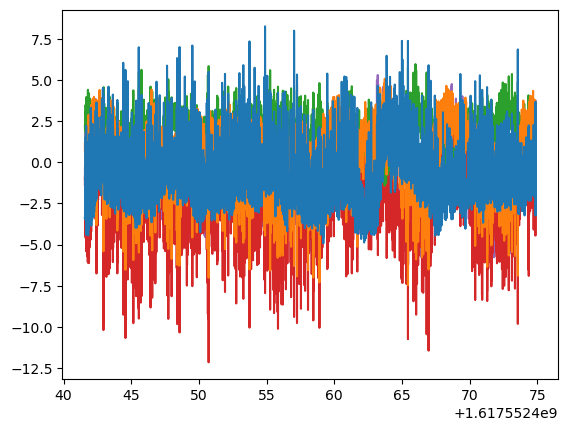

In [103]:
import matplotlib.pyplot as plt

ind = slice(450000, 500000, 10)
for i in range(5):
    plt.plot(analysis.t[ind], analysis.c[ind,][:, i], zorder=-i)

In [104]:
context_dim, latent_dim

(20, 20)

In [105]:
model_name = "rat_mpfc_model1_c20z20"

from flax import serialization
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage()
insert_key = {
    "model_name": model_name,
    "encoder_args": encoder_args,
    "context_args": context_args,
    "rate_args": rate_args,
    "latent_dim": latent_dim,
    "context_dim": context_dim,
    "learned_params": serialization.to_bytes(params),
    "input_shape": np.array(x_train.shape[-1]),
}

C3POStorage().insert1(insert_key)
analysis.save_embedding(f"/stelmo/sam/c3po_results/{model_name}_embedding.npz")